# Flower Classification with Data Augmentation

Image classification on a small flower dataset containing 17 species, 80 images per specie. The goal of this project is to use data augmentation to improve the performance of my model.

As model we use a minified VGG, inspired from Dr. Adrian Rosebrock.

Download dataset: http://www.robots.ox.ac.uk/~vgg/data/flowers/17/

In [27]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from aspectawarepreprocessor import AspectAwarePreprocessor
from miniVGG import MiniVGG
from tensorflow.keras.optimizers import SGD
from imutils import paths
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib  inline

## Data Preprocessing

In [2]:
IMAGES_PATH = './data/images'

In [3]:
# Loading images and extract class names

image_paths = list(paths.list_images(IMAGES_PATH))
classes = list(set([int(path.split(os.path.sep)[-2]) for path in image_paths]))

In [ ]:
# Load the images
data = []
labels = []

aap = AspectAwarePreprocessor(width=64, height=64)

for path in image_paths:
    image = load_img(path)
    image = img_to_array(image)
    
    # Preprocess image
    image = aap.preprocess(image)
    image = image / 255.0
    
    # Get label
    label = int(path.split(os.path.sep)[-2])
    
    # Add image and label
    data.append(image)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)

In [5]:
# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=101)

In [6]:
# One-Hot Encode Labels
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

## No Data Augmentation training

Establishing a baseline

In [7]:
model = MiniVGG.build(width=64, height=64, depth=3, classes=len(classes))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.05), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, verbose=1)

Train on 1020 samples, validate on 340 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1020/1020 [==============================] - 63s 62ms/sample - loss: 3.0730 - acc: 0.2588 - val_loss: 4.2729 - val_acc: 0.1676
Epoch 2/100
1020/1020 [==============================] - 60s 59ms/sample - loss: 1.8937 - acc: 0.4451 - val_loss: 2.6732 - val_acc: 0.2265
Epoch 3/100
1020/1020 [==============================] - 62s 61ms/sample - loss: 1.4081 - acc: 0.5784 - val_loss: 2.7578 - val_acc: 0.1912
Epoch 4/100
1020/1020 [==============================] - 62s 61ms/sample - loss: 1.0707 - acc: 0.6686 - val_loss: 3.0290 - val_acc: 0.2118
Epoch 5/100
1020/1020 [==============================] - 56s 55ms/sample - loss: 0.7266 - acc: 0.7549 - val_loss: 2.7470 - val_acc: 0.2500
Epoch 6/100
1020/1020 [==============================] - 57s 56ms/sample - loss: 0.5682 - acc: 0.8176 - val_loss: 2.5824 - val_acc: 0.2559
Epoch 7/100
1020/1020 [==============================] - 57s 56ms/sampl

In [10]:
# Evaluate model
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.28      0.35        25
           1       0.41      0.37      0.39        19
           2       0.45      0.48      0.47        21
           3       0.75      0.79      0.77        19
           4       0.90      0.33      0.49        27
           5       0.91      0.91      0.91        23
           6       0.92      0.58      0.71        19
           7       0.13      0.24      0.17        17
           8       0.62      0.72      0.67        18
           9       0.82      0.90      0.86        20
          10       0.80      0.76      0.78        21
          11       0.68      0.65      0.67        23
          12       0.42      0.69      0.52        16
          13       0.21      0.53      0.30        15
          14       0.38      0.31      0.34        16
          15       0.86      0.60      0.71        20
          16       1.00      0.67      0.80        21

   micro avg       0.58   

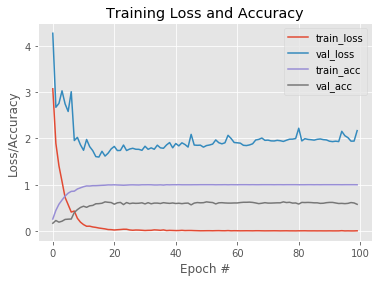

In [11]:
# Plot
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,100), H.history['loss'], label='train_loss')
plt.plot(np.arange(0,100), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0,100), H.history['acc'], label='train_acc')
plt.plot(np.arange(0,100), H.history['val_acc'], label='val_acc')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Data Augmentation training

In [14]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [15]:
model_aug = MiniVGG.build(width=64, height=64, depth=3, classes=len(classes))
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.05), metrics=['accuracy'])

In [16]:
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test),
                        steps_per_epoch=len(x_train) // 32, epochs=100, verbose=1)

Epoch 1/100
32/32 [==============================] - 45s 1s/step - loss: 1.9795 - acc: 0.5500 - val_loss: 2.7215 - val_acc: 0.5324
Epoch 2/100
32/32 [==============================] - 43s 1s/step - loss: 1.6578 - acc: 0.5667 - val_loss: 5.7783 - val_acc: 0.3971
Epoch 3/100
32/32 [==============================] - 44s 1s/step - loss: 1.4956 - acc: 0.5765 - val_loss: 2.2843 - val_acc: 0.5412
Epoch 4/100
32/32 [==============================] - 42s 1s/step - loss: 1.3117 - acc: 0.6137 - val_loss: 2.5345 - val_acc: 0.4941
Epoch 5/100
32/32 [==============================] - 42s 1s/step - loss: 1.2486 - acc: 0.6216 - val_loss: 2.1262 - val_acc: 0.5441
Epoch 6/100
32/32 [==============================] - 44s 1s/step - loss: 1.2168 - acc: 0.6245 - val_loss: 1.1677 - val_acc: 0.6706
Epoch 7/100
32/32 [==============================] - 39s 1s/step - loss: 1.2150 - acc: 0.6333 - val_loss: 1.4857 - val_acc: 0.6147
Epoch 8/100
32/32 [==============================] - 39s 1s/step - loss: 1.0601 - a

Epoch 39/100
32/32 [==============================] - 40s 1s/step - loss: 0.4791 - acc: 0.8471 - val_loss: 1.0778 - val_acc: 0.7118
Epoch 40/100
32/32 [==============================] - 50s 2s/step - loss: 0.4792 - acc: 0.8333 - val_loss: 1.0599 - val_acc: 0.7176
Epoch 41/100
32/32 [==============================] - 57s 2s/step - loss: 0.4568 - acc: 0.8392 - val_loss: 0.9640 - val_acc: 0.7471
Epoch 42/100
32/32 [==============================] - 77s 2s/step - loss: 0.4520 - acc: 0.8520 - val_loss: 0.9249 - val_acc: 0.7353
Epoch 43/100
32/32 [==============================] - 57s 2s/step - loss: 0.4224 - acc: 0.8578 - val_loss: 0.8840 - val_acc: 0.7765
Epoch 44/100
32/32 [==============================] - 51s 2s/step - loss: 0.4234 - acc: 0.8569 - val_loss: 0.9803 - val_acc: 0.7441
Epoch 45/100
32/32 [==============================] - 54s 2s/step - loss: 0.3311 - acc: 0.8765 - val_loss: 0.8939 - val_acc: 0.7618
Epoch 46/100
32/32 [==============================] - 53s 2s/step - loss: 0.

Epoch 77/100
32/32 [==============================] - 38s 1s/step - loss: 0.2455 - acc: 0.9176 - val_loss: 1.0480 - val_acc: 0.7559
Epoch 78/100
32/32 [==============================] - 38s 1s/step - loss: 0.2952 - acc: 0.8951 - val_loss: 1.1070 - val_acc: 0.7441
Epoch 79/100
32/32 [==============================] - 38s 1s/step - loss: 0.2632 - acc: 0.9108 - val_loss: 1.0791 - val_acc: 0.7265
Epoch 80/100
32/32 [==============================] - 39s 1s/step - loss: 0.2366 - acc: 0.9108 - val_loss: 0.9410 - val_acc: 0.7588
Epoch 81/100
32/32 [==============================] - 38s 1s/step - loss: 0.2847 - acc: 0.9069 - val_loss: 1.0272 - val_acc: 0.7588
Epoch 82/100
32/32 [==============================] - 38s 1s/step - loss: 0.2396 - acc: 0.9235 - val_loss: 1.2535 - val_acc: 0.7118
Epoch 83/100
32/32 [==============================] - 38s 1s/step - loss: 0.2250 - acc: 0.9294 - val_loss: 0.9884 - val_acc: 0.7559
Epoch 84/100
32/32 [==============================] - 38s 1s/step - loss: 0.

In [17]:
# Evaluate model
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.52      0.63        25
           1       0.69      0.58      0.63        19
           2       0.88      0.71      0.79        21
           3       0.82      0.95      0.88        19
           4       0.81      0.81      0.81        27
           5       0.91      0.87      0.89        23
           6       0.79      1.00      0.88        19
           7       0.40      0.59      0.48        17
           8       0.94      0.83      0.88        18
           9       0.82      0.90      0.86        20
          10       0.83      0.90      0.86        21
          11       0.69      0.87      0.77        23
          12       0.80      0.75      0.77        16
          13       0.60      0.80      0.69        15
          14       0.75      0.56      0.64        16
          15       0.88      0.70      0.78        20
          16       0.94      0.81      0.87        21

   micro avg       0.78   

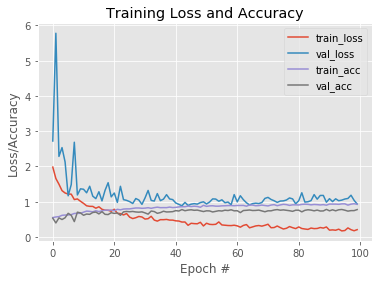

In [18]:
# Plot
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,100), H.history['loss'], label='train_loss')
plt.plot(np.arange(0,100), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0,100), H.history['acc'], label='train_acc')
plt.plot(np.arange(0,100), H.history['val_acc'], label='val_acc')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Using pre-trained VGG16

In [5]:
image_paths = list(paths.list_images(IMAGES_PATH))
classes = [int(path.split(os.path.sep)[-2]) for path in image_paths]

In [7]:
lb = LabelBinarizer()
classes = lb.fit_transform(classes)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(image_paths, classes, test_size=0.2, shuffle=True)

In [14]:
# VGG16 Model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
# Extract VGG16 features from the training set
train_features = []
for path in x_train:
    image = load_img(path, target_size=(224,224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    pred = model.predict(image)
    train_features.append(pred.flatten())

In [26]:
# Extract VGG16 features from the test set
test_features = []
for path in x_test:
    image = load_img(path, target_size=(224,224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    pred = model.predict(image)
    test_features.append(pred.flatten())

In [30]:
y_train = np.array([y.argmax() for y in y_train])
y_test = np.array([y.argmax() for y in y_test])

In [32]:
# Fitting the logistic regression classifier
clf = LogisticRegression(C=10.0)

clf.fit(train_features, y_train)
clf.score(test_features, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8823529411764706